Begin by importing all necessary libraries and allowing us to view all dataframe columns.

In [1]:
#! pip install geopandas

In [2]:
import math
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_columns', None)

Then import all data files.

In [3]:
demo_ref_raw = pd.read_csv('demographicref.csv') #demographic reference data
econ_ref_raw = pd.read_csv('econref.csv') #economic reference data
health_expen_raw = pd.read_csv('healthexpenditure.csv') #healthcare expenditure data
health_qual_raw = pd.read_csv('healthquality.csv') #healthcare quality data
health_resor_raw = pd.read_csv('healthresources.csv') #healthcare resources data
health_util_raw = pd.read_csv('healthutil.csv') #healthcare utilization data
social_proc_raw = pd.read_csv('socialprotection.csv') #social healthcare protection data
worker_migr_raw = pd.read_csv('healthworkmigration.csv') #healthcare worker migration data

The final dataset cannot be loaded past the 284,614th line, so in order to avoid having partial data on one variable we needed to cut the last 40,000 or so entries.

In [4]:
health_stat_raw = pd.read_csv('healthstatus.csv',nrows = 284583) #health status data

Remove unwanted columns of data.

In [5]:
demo_ref_col = demo_ref_raw[['Variable','Measure','Country','Year','Value']]
econ_ref_col = econ_ref_raw[['Variable', 'Measure', 'Country','Year', 'Value']]
health_expen_col = health_expen_raw[['Financing scheme', 'Function','Provider', 'Measure', 'Country', 'Year', 'Unit', 'Value']]
health_qual_col = health_qual_raw[['Country','Periods','Indicator','Gender','Age Group','Value','Value.1']]
health_resor_col = health_resor_raw[['Variable','Measure','Country','Year','Value']]
health_util_col = health_util_raw[['Variable','Measure','Country','Year','Value']]
social_proc_col = social_proc_raw[['Variable','Measure','Country','Year','Value']]
worker_migr_col = worker_migr_raw[['Country','Variable','Country of origin','Year','Value']]
health_stat_col = health_stat_raw[['Variable','Measure','Country','Year','Value']]

In [6]:
migr_list = []

for country in worker_migr_col["Country"]:
    if (worker_migr_col["Country"].value_counts()[country] > 50) and (country not in migr_list):
        migr_list.append(country)

Remove unwanted rows of data. Typically rows containing data measured in units that cannot be compared between countries (e.g. in local currency or raw numbers of incidents). Also removing rows containing variables with few observations or which are unlikely to be helpful for our purposes. Not all data sets required this.

In [7]:
econ_ref_clean = econ_ref_col.loc[(econ_ref_col['Measure']=='National currency unit per US$, PPP')|
                       (econ_ref_col['Measure']=='/capita, US$ purchasing power parity')|
                       (econ_ref_col['Measure']=='Million US$ at exchange rate')|
                       (econ_ref_col['Measure']=='/capita, US$ exchange rate ')|
                       (econ_ref_col['Measure']=='Current prices in NCU')|
                       (econ_ref_col['Country']=='/capita, US$ purchasing power parity')]

health_expen_clean = health_expen_col.loc[health_expen_col['Measure']=='Share of gross domestic product']

health_qual_clean = health_qual_col.loc[((health_qual_col['Value']=='Age-sex standardised rate per 100 000 population')|
               (health_qual_col['Value']=='Age-sex standardised rate per 100 patients')|
               (health_qual_col['Value']=='Age-standardised survival (%) '))&
                (health_qual_col['Gender']=='Total')] 

health_resor_clean = health_resor_col.loc[(health_resor_col['Measure']=='Density per 1 000 population (head counts)')|
                (health_resor_col['Measure']=='Per million population')|
                (health_resor_col['Measure']=='% of total physicians (head counts)')|
                (health_resor_col['Measure']=='Per 1 000 population')|
                (health_resor_col['Measure']=='% of physicians (head counts)')|
                (health_resor_col['Measure']=='Per 100 000 population')|
                (health_resor_col['Measure']=='% of total hospital employment (head counts)')|
                (health_resor_col['Measure']=='Per 1 000 live births')|
                (health_resor_col['Measure']=='Salaried, income, US$ exchange rate')] 

health_util_clean = health_util_col.loc[(health_util_col['Measure']=='Per 100 000 population')|
               (health_util_col['Measure']=='% performed as inpatient cases')|
               (health_util_col['Measure']=='% performed as day cases')|
               (health_util_col['Measure']=='Per 100 000 females')|
               (health_util_col['Measure']=='Inpatient cases per 100 000 population ')|
               (health_util_col['Measure']=='Total procedures per 100 000 population')|
               (health_util_col['Measure']=='Day cases per 100 000 population')|
               (health_util_col['Measure']=='Per 1 000 population')]

social_proc_clean = social_proc_col.loc[(social_proc_col['Measure']=='% of total population')|
                                        (social_proc_col['Measure']=='% of total population covered')] 

health_stat_clean = health_stat_col.loc[(health_stat_col['Measure']=='Deaths per 100 000 females (standardised rates)')|
               (health_stat_col['Measure']=='Deaths per 100 000 females (crude rates)')|
               (health_stat_col['Measure']=='Years lost, /100 000 females, aged 75 years old')|
               (health_stat_col['Measure']=='Deaths per 100 000 males (standardised rates)')|
               (health_stat_col['Measure']=='Deaths per 100 000 population (standardised rates)')|
               (health_stat_col['Measure']=='Deaths per 100 000 males (crude rates)')|
               (health_stat_col['Measure']=='Years lost, /100 000 males, aged 75 years old')|
               (health_stat_col['Measure']=='Years lost, /100 000 population, aged 75 years old')|
               (health_stat_col['Measure']=='Deaths per 100 000 population (crude rates)')|
               (health_stat_col['Measure']=='% of population (crude rate)')|
               (health_stat_col['Measure']=='Years')]

Next we have to pivot the dataframes.

In [8]:
worker_migr = worker_migr_col.pivot_table(index = ['Country','Year'], columns = ['Variable'], values = 'Value')
demo_ref = demo_ref_col.pivot_table(index = ['Country','Year'], columns = ['Measure','Variable'], values = 'Value')
econ_ref = econ_ref_clean.pivot_table(index = ['Country','Year'], columns = ['Measure','Variable'], values = 'Value')
health_expen = health_expen_clean.pivot_table(index = ['Country','Year'], columns = ['Measure','Function'], values = 'Value')
health_qual = health_qual_clean.pivot_table(index = ['Country','Periods','Age Group'], columns = ['Value','Indicator'], values = 'Value.1')
health_resor = health_resor_clean.pivot_table(index = ['Country','Year'], columns = ['Measure','Variable'], values = 'Value')
health_util = health_util_clean.pivot_table(index = ['Country','Year'], columns = ['Measure','Variable'], values = 'Value')
social_proc = social_proc_clean.pivot_table(index = ['Country','Year'], columns = ['Measure','Variable'], values = 'Value')
health_stat = health_stat_clean.pivot_table(index = ['Country','Year'], columns = ['Measure','Variable'], values = 'Value')

In [9]:
migr_list

['Australia',
 'Austria',
 'Belgium',
 'Canada',
 'Czechia',
 'Denmark',
 'Finland',
 'France',
 'Germany',
 'Hungary',
 'Ireland',
 'Italy',
 'Netherlands',
 'New Zealand',
 'Norway',
 'Poland',
 'Sweden',
 'Switzerland',
 'Türkiye',
 'United Kingdom',
 'United States',
 'Chile',
 'Estonia',
 'Israel',
 'Slovenia',
 'Greece',
 'Lithuania',
 'Latvia',
 'Colombia']

In [10]:
reference = pd.merge(demo_ref,econ_ref, on = ['Country','Year'])

## Relationship Between Health Outcome and Migration of Healthcare Providers 
**Preliminary Analysis**

### Measures of Health Outcome

* Acute care outcome: \
Number of deaths in any hospital and out of hospital that occurred within 30 days of the admission date of the denominator cases.

In [11]:
mor_val =  health_qual_clean["Value"] == "Age-sex standardised rate per 100 patients"
hos_val =  health_qual_clean["Value"] == "Age-sex standardised rate per 100 000 population" #Measure of mortality rate and hospital admission/readmission rate

health_qual_clean['Periods'] = pd.to_numeric(health_qual_clean['Periods'])
yrs =  health_qual_clean["Periods"] > 2014

mor_ind = health_qual_clean["Indicator"].str.contains("mortality")
hos_ind = health_qual_clean["Indicator"].str.contains("hospital admission")
re_hos_ind = health_qual_clean["Indicator"].str.contains("hospital readmissions")

qual_mor = health_qual_clean[mor_ind & yrs & mor_val]
qual_hos = health_qual_clean[hos_ind & yrs & hos_val]
qual_re_hos = health_qual_clean[re_hos_ind & yrs & hos_val]


mor_countries = set(qual_mor['Country'].unique())
hos_countries = set(qual_hos['Country'].unique())
re_hos_countries = set(qual_re_hos['Country'].unique())

common_countries = mor_countries & hos_countries & re_hos_countries #filtering out countries wit

qual_mor_filtered = qual_mor[qual_mor['Country'].isin(common_countries)]
qual_hos_filtered = qual_hos[qual_hos['Country'].isin(common_countries)]
qual_re_hos_filtered = qual_re_hos[qual_re_hos['Country'].isin(common_countries)]

/tmp/ipykernel_2124/2430584609.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  health_qual_clean['Periods'] = pd.to_numeric(health_qual_clean['Periods'])


In [12]:
summary_qual_mor = pd.DataFrame(qual_mor_filtered.groupby(['Country'])['Value.1'].mean()).rename(columns={'Value.1': 'Mortality'})
summary_qual_hos = pd.DataFrame(qual_hos_filtered.groupby(['Country'])['Value.1'].mean()).rename(columns={'Value.1': 'Hospital Admission'})
summary_qual_re_hos = pd.DataFrame(qual_re_hos_filtered.groupby(['Country'])['Value.1'].mean()).rename(columns={'Value.1': 'Hospital Readmission'})

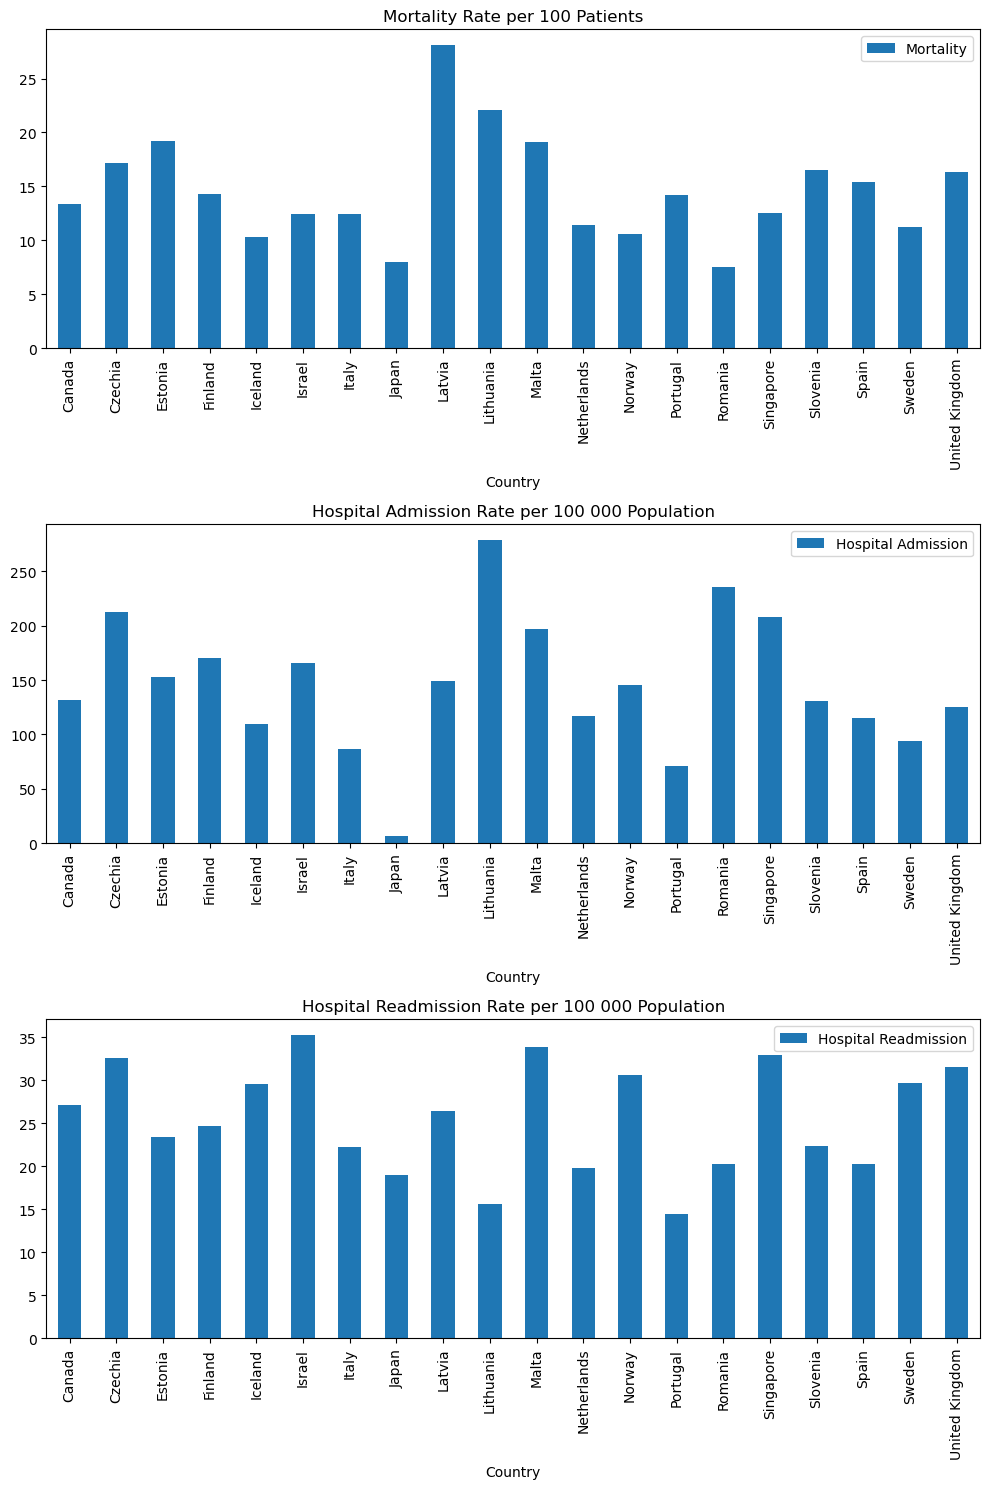

In [13]:
fig, ax = plt.subplots(3, 1, figsize=(10, 15))
ax[0] = summary_qual_mor.plot.bar(ax=ax[0])
ax[0].set_title("Mortality Rate per 100 Patients")
ax[1] = summary_qual_hos.plot.bar(ax=ax[1])
ax[1].set_title("Hospital Admission Rate per 100 000 Population")
ax[2] = summary_qual_re_hos.plot.bar(ax=ax[2])
ax[2].set_title("Hospital Readmission Rate per 100 000 Population")
plt.tight_layout()

### Health Workforce Migration

In [14]:
worker_migr_col #Cleaning the data to avoid multi level indexing
worker_migr_2 = worker_migr_col.pivot_table(
                index = ["Year", "Country"],
                columns = ["Variable"],
                values = ['Value'])
worker_migr_2.columns.names = [None] * len(worker_migr_2.columns.names)
worker_migr_2.columns = worker_migr_2.columns.droplevel(0) 

In [15]:
worker_migr_2.index = worker_migr_2.index.set_levels(worker_migr_2.index.levels[0].astype(int), level=0)#Changing year index to numeric
worker_migr_2 = worker_migr_2[worker_migr_2.index.get_level_values('Year') > 2014]
worker_migr_2_filtered = worker_migr_2[worker_migr_2.index.get_level_values('Country').isin(common_countries)]

In [16]:
worker_migr_2_filtered

% of foreign-trained doctors  % of foreign-trained nurses  \
Year Country                                                                
2015 Canada                           24.097                         7.73   
     Czechia                           6.100                          NaN   
     Estonia                           3.040                         0.06   
     Finland                          17.270                         1.38   
     Israel                           58.480                         8.98   
...                                      ...                          ...   
2022 Israel                           57.980                        10.89   
     Italy                             0.970                         5.22   
     Lithuania                         0.720                         0.45   
     Slovenia                         15.400                          NaN   
     Spain                               NaN                          NaN   

                Domestically-trained doctors  Domestically-trained nurses  \
Year Country                                                                
2015 Canada                          71873.0                     358472.0   
     Czechia                         39337.0                          NaN   
     Estonia                          6225.0                      12838.0   
     Finland                         18758.0                     104333.0   
     Israel                          11459.0                      45122.0   
...                                      ...                          ...   
2022 Israel                          14087.0                      56329.0   
     Italy                          429415.0                     431343.0   
     Lithuania                       13866.0                      24690.0   
     Slovenia                         6005.0                          NaN   
     Spain                               NaN                          NaN   

                Foreign-trained doctors - Annual inflow  \
Year Country                                              
2015 Canada                                      2849.0   
     Czechia                                      241.0   
     Estonia                                       29.0   
     Finland                                      213.0   
     Israel                                       777.0   
...                                                 ...   
2022 Israel                                      1273.0   
     Italy                                        291.0   
     Lithuania                                     30.0   
     Slovenia                                      45.0   
     Spain                                       4969.0   

                Foreign-trained doctors - Stock  \
Year Country                                      
2015 Canada                             22942.0   
     Czechia                             2556.0   
     Estonia                              195.0   
     Finland                             3937.0   
     Israel                             16158.0   
...                                         ...   
2022 Israel                             19455.0   
     Italy                               4229.0   
     Lithuania                            102.0   
     Slovenia                            1093.0   
     Spain                                  NaN   

                Foreign-trained nurses - Annual inflow  \
Year Country                                             
2015 Canada                                     2428.0   
     Czechia                                       NaN   
     Estonia                                       4.0   
     Finland                                      58.0   
     Israel                                      154.0   
...                                                ...   
2022 Israel                                      616.0   
     Italy                                       765.0   


/tmp/ipykernel_2124/3391833860.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  summary_imm = pd.DataFrame (worker_migr_2_filtered.groupby(['Country'])['Foreign-trained doctors - Annual inflow', 'Foreign-trained nurses - Annual inflow'].mean()).fillna(0)


<AxesSubplot: xlabel='Country'>

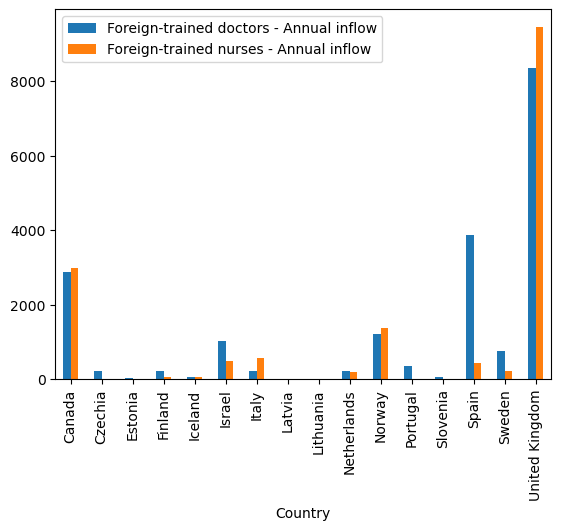

In [17]:
summary_imm = pd.DataFrame (worker_migr_2_filtered.groupby(['Country'])['Foreign-trained doctors - Annual inflow', 'Foreign-trained nurses - Annual inflow'].mean()).fillna(0)
summary_imm.plot.bar()

In [18]:
imm_qual = pd.merge(summary_qual_hos, summary_qual_re_hos, on = ['Country'])
imm_qual = pd.merge(imm_qual, summary_qual_mor, on = ['Country'])
imm_qual = pd.merge(imm_qual, summary_imm, on = ['Country'])
imm_qual

,Hospital Admission,Hospital Readmission,Mortality,Foreign-trained doctors - Annual inflow,Foreign-trained nurses - Annual inflow
Country,,,,,
Canada,131.593878,27.125000,13.335714,2884.571429,2980.428571
Czechia,213.106122,32.528571,17.161905,206.500000,0.000000
Estonia,152.979592,23.391667,19.176190,17.875000,3.500000
Finland,170.736735,24.665000,14.321429,220.142857,46.714286
Iceland,109.300000,29.556250,10.350000,54.666667,48.333333
Israel,165.365306,35.303571,12.395238,1022.500000,481.500000
Italy,86.273469,22.195833,12.416667,210.750000,568.250000
Latvia,148.846429,26.412500,28.156250,4.714286,1.000000
Lithuania,279.423214,15.537500,22.112500,11.000000,6.500000


In [19]:
correlation_matrix = imm_qual.corr()
correlation_matrix

,Hospital Admission,Hospital Readmission,Mortality,Foreign-trained doctors - Annual inflow,Foreign-trained nurses - Annual inflow
Hospital Admission,1.000000,0.037164,0.491925,-0.169739,-0.119176
Hospital Readmission,0.037164,1.000000,-0.227809,0.261194,0.330844
Mortality,0.491925,-0.227809,1.000000,-0.067667,-0.046392
Foreign-trained doctors - Annual inflow,-0.169739,0.261194,-0.067667,1.000000,0.919462
Foreign-trained nurses - Annual inflow,-0.119176,0.330844,-0.046392,0.919462,1.000000


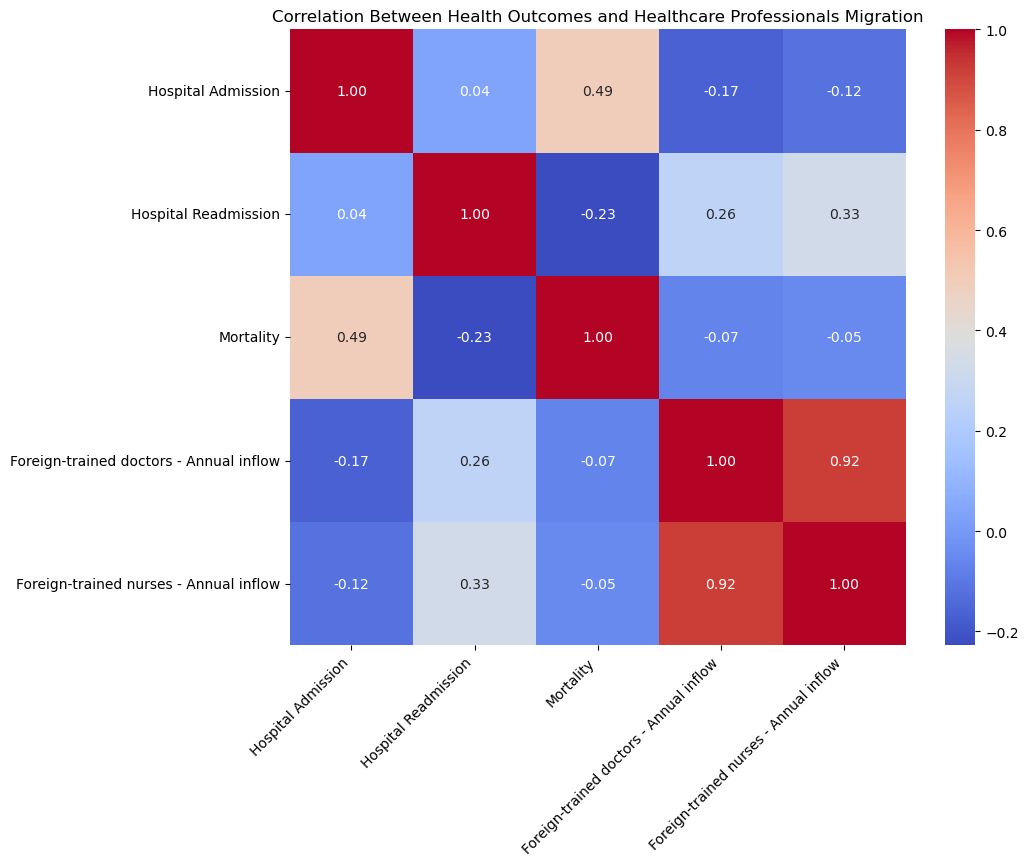

In [20]:
plt.figure(figsize=(10, 8))  
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.title('Correlation Between Health Outcomes and Healthcare Professionals Migration')

plt.show()

## Results
Countries with a higher number of mortality, hospital admission, and readmission tend to have a lower number of migrant healthcare providers. However, this may be attributed to  

## Insurance, Healthcare Spending, and Remuneration as Predictive Factors of Healthcare Professional Migration

**Preliminary Analysis**

In [21]:
gdp_ppp = reference["/capita, US$ purchasing power parity"]["Gross domestic product (GDP)"]
hlth_gdp_share = health_expen["Share of gross domestic product"]["Current expenditure on health (all functions)"]
inpt_gdp_share = health_expen["Share of gross domestic product"]["Inpatient curative and rehabilitative care"]
prev_gdp_share = health_expen["Share of gross domestic product"]["Preventive care"]
gp_sal_usd = health_resor["Salaried, income, US$ exchange rate"]["Remuneration of general practitioners"]
nur_sal_usd = health_resor["Salaried, income, US$ exchange rate"]["Remuneration of hospital nurses"]
spec_sal_usd = health_resor["Salaried, income, US$ exchange rate"]["Remuneration of specialists"]
gov_hi_pct = social_proc["% of total population"]["Government/compulsory health insurance coverage"]
for_doc_pct = worker_migr["% of foreign-trained doctors"]
for_nur_pct = worker_migr["% of foreign-trained nurses"]
for_doc_inf = worker_migr["Foreign-trained doctors - Annual inflow"]
for_nur_inf = worker_migr["Foreign-trained nurses - Annual inflow"]

In [22]:
doc_pct_pred_list = [gdp_ppp,hlth_gdp_share,gp_sal_usd,spec_sal_usd,gov_hi_pct,for_doc_pct]
doc_pct_pred = pd.concat(doc_pct_pred_list,axis=1).dropna()
doc_pct_pred_corr = doc_pct_pred.corr()["% of foreign-trained doctors"]

doc_inf_pred_list = [gdp_ppp,hlth_gdp_share,gp_sal_usd,spec_sal_usd,gov_hi_pct,for_doc_inf]
doc_inf_pred = pd.concat(doc_inf_pred_list,axis=1).dropna()
doc_inf_pred_corr = doc_inf_pred.corr()["Foreign-trained doctors - Annual inflow"]

In [23]:
nur_pct_pred_list = [gdp_ppp,hlth_gdp_share,nur_sal_usd,gov_hi_pct,for_nur_pct]
nur_pct_pred = pd.concat(nur_pct_pred_list,axis=1).dropna()
nur_pct_pred_corr = nur_pct_pred.corr()["% of foreign-trained nurses"]

nur_inf_pred_list = [gdp_ppp,hlth_gdp_share,nur_sal_usd,gov_hi_pct,for_nur_inf]
nur_inf_pred = pd.concat(nur_inf_pred_list,axis=1).dropna()
nur_inf_pred_corr = nur_inf_pred.corr()["Foreign-trained nurses - Annual inflow"]

In [24]:
print("Percentage of foreign-trained doctors \n" + str(doc_pct_pred_corr)+"\n")
print("Inflow of foreign-trained doctors \n" + str(doc_inf_pred_corr)+"\n")
print("Percentage of foreign-trained nurses \n" + str(nur_pct_pred_corr)+"\n")
print("Inflow of foreign-trained nurses \n" + str(nur_inf_pred_corr)+"\n")

Percentage of foreign-trained doctors 
Gross domestic product (GDP)                       0.075365
Current expenditure on health (all functions)      0.188999
Remuneration of general practitioners              0.294342
Remuneration of specialists                        0.526637
Government/compulsory health insurance coverage    0.116792
% of foreign-trained doctors                       1.000000
Name: % of foreign-trained doctors, dtype: float64

Inflow of foreign-trained doctors 
Gross domestic product (GDP)                       0.119307
Current expenditure on health (all functions)      0.167185
Remuneration of general practitioners              0.057669
Remuneration of specialists                        0.217792
Government/compulsory health insurance coverage    0.072621
Foreign-trained doctors - Annual inflow            1.000000
Name: Foreign-trained doctors - Annual inflow, dtype: float64

Percentage of foreign-trained nurses 
Gross domestic product (GDP)                       0.

## Relationship Between Domestic and Foreign-Trained Medical Professionals

In [25]:
#create new column for percentage of domestically trained healthcare workers
#sum domestic trained doctors and nurses, divide by total
worker_migr['%_of_domestic_trained_healthcare_workers'] = (
    (worker_migr['Domestically-trained doctors'] + worker_migr['Domestically-trained nurses']) /
    (worker_migr['Total number of doctors'] + worker_migr['Total number of nurses'])
) * 100

worker_migr['%_of_foreign_trained_healthcare_workers'] = (
    (worker_migr['Foreign-trained doctors - Stock'] + worker_migr['Foreign-trained nurses - Stock']) /
    (worker_migr['Total number of doctors'] + worker_migr['Total number of nurses'])
) * 100


worker_migr['%_of_workers_unknown_training'] = 100 - (worker_migr['%_of_foreign_trained_healthcare_workers']\
                                                    + worker_migr['%_of_domestic_trained_healthcare_workers'])


# Reset index
worker_migr= worker_migr.reset_index()

In [26]:
worker_migr.head()

Variable,Country,Year,% of foreign-trained doctors,% of foreign-trained nurses,Domestically-trained doctors,Domestically-trained nurses,Foreign-trained doctors - Annual inflow,Foreign-trained doctors - Stock,Foreign-trained nurses - Annual inflow,Foreign-trained nurses - Stock,Total number of doctors,Total number of nurses,Unknown place of training (doctors),Unknown place of training (nurses),of which native-born but foreign-trained (doctors),of which native-born but foreign-trained (nurses),%_of_domestic_trained_healthcare_workers,%_of_foreign_trained_healthcare_workers,%_of_workers_unknown_training
0,Australia,2012,33.076,NaN,46938.0,NaN,NaN,24892.0,NaN,NaN,75258.0,NaN,3427.0,NaN,NaN,NaN,NaN,NaN,NaN
1,Australia,2013,29.701,17.218,48405.0,193249.0,NaN,23159.0,NaN,44283.0,77974.0,257189.0,6410.0,19657.0,279.0,669.0,72.100441,20.122150,7.777410
2,Australia,2014,31.734,18.323,51210.0,210980.0,2685.0,25694.0,3444.0,48533.0,80968.0,264876.0,4064.0,5363.0,285.0,541.0,75.811638,21.462567,2.725795
3,Australia,2015,32.349,18.118,53503.0,217108.0,2717.0,27008.0,2008.0,49126.0,83490.0,271151.0,2979.0,4917.0,302.0,499.0,76.305616,21.467907,2.226477
4,Australia,2016,32.678,18.292,55727.0,224447.0,2726.0,28283.0,2695.0,51180.0,86550.0,279789.0,2540.0,4162.0,304.0,958.0,76.479436,21.691111,1.829453


In [27]:
worker_migr_to_plot = worker_migr[['Country', 'Year', '%_of_domestic_trained_healthcare_workers',\
                                   '%_of_foreign_trained_healthcare_workers','%_of_workers_unknown_training']] \
                        .groupby('Country') \
                        .mean() \
                        .dropna()\
                        .reset_index()\

worker_migr_to_plot.head()

Variable,Country,Year,%_of_domestic_trained_healthcare_workers,%_of_foreign_trained_healthcare_workers,%_of_workers_unknown_training
0,Australia,2016.5,75.906449,21.387244,2.706307
1,Austria,2016.0,89.054196,10.917625,0.028179
2,Belgium,2016.0,94.815600,5.184400,0.000000
3,Canada,2015.5,88.293546,11.062368,0.644086
4,Chile,2016.5,89.164194,10.704136,0.131670


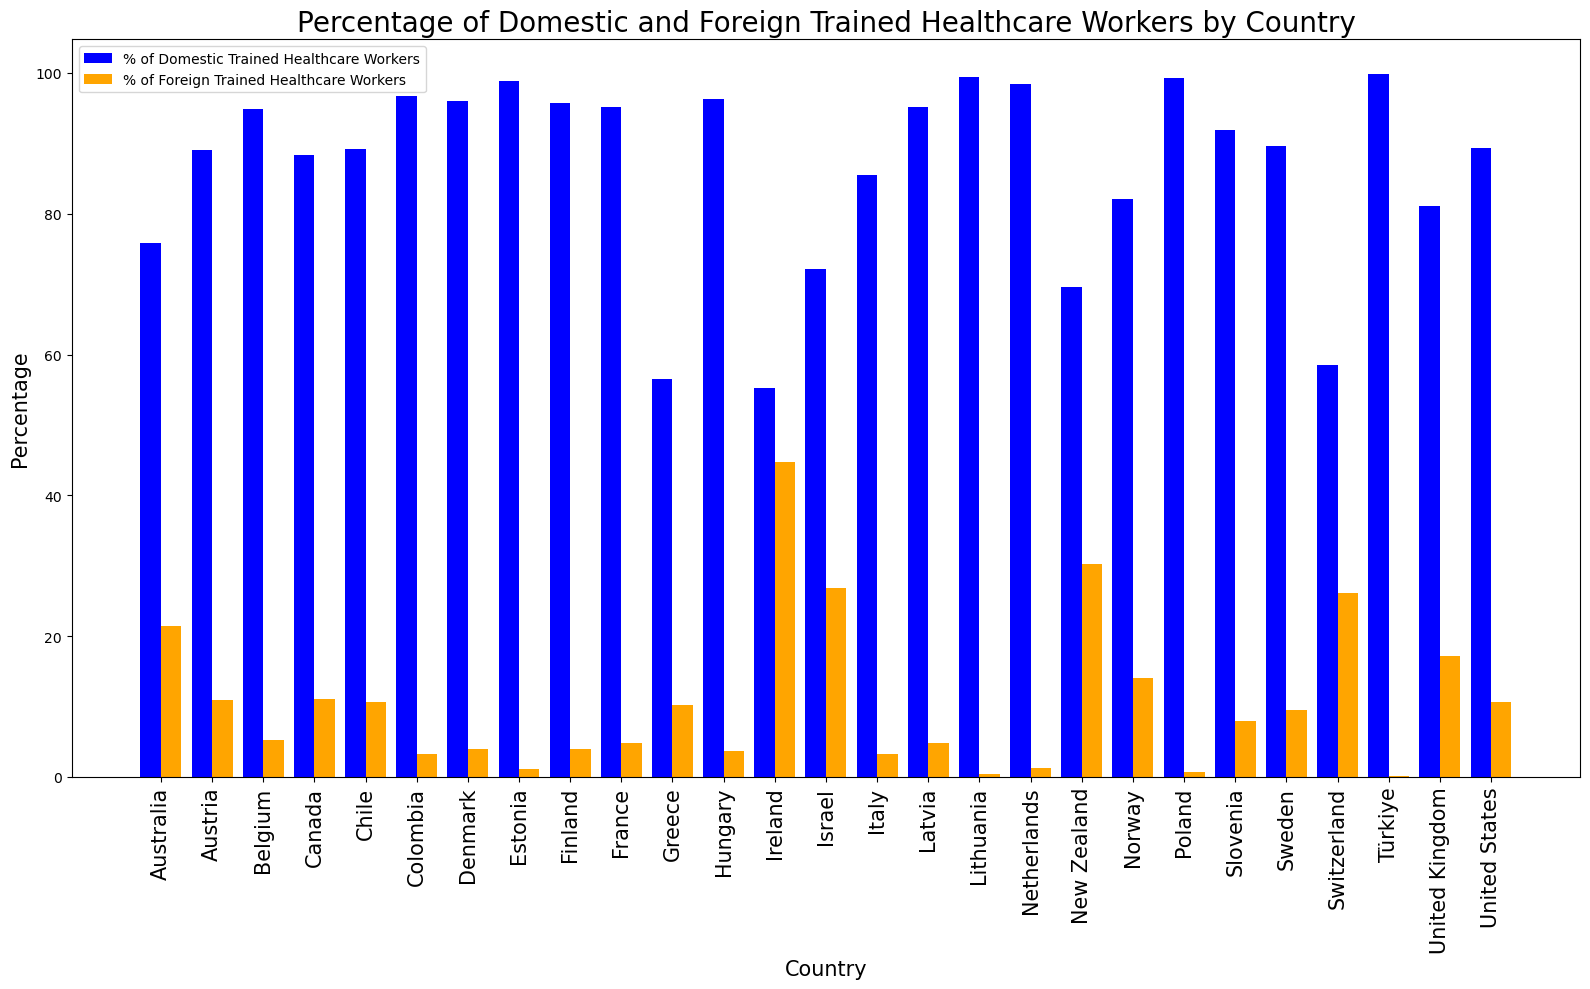

In [28]:
bar_width = 0.4

# bar positions
r1 = np.arange(len(worker_migr_to_plot['Country']))
r2 = [x + bar_width for x in r1]

plt.figure(figsize=(16, 10))

#domestic healthcare workers
plt.bar(r1, worker_migr_to_plot['%_of_domestic_trained_healthcare_workers'], color='blue', width=bar_width, label='% of Domestic Trained Healthcare Workers')

#foreign healthcare workers
plt.bar(r2, worker_migr_to_plot['%_of_foreign_trained_healthcare_workers'], color='orange', width=bar_width, label='% of Foreign Trained Healthcare Workers')

plt.xticks([r + bar_width/2 for r in range(len(worker_migr_to_plot['Country']))], worker_migr_to_plot['Country'], rotation=90, size = 15)

plt.xlabel('Country', size = 15)
plt.ylabel('Percentage', size = 15)
plt.title('Percentage of Domestic and Foreign Trained Healthcare Workers by Country', size = 20)
plt.legend()
plt.tight_layout()
plt.show()


## Maps

**Map of doctor inflow, map of foreign doctor percentage, map of nurse inflow, map of foreign nurse percentage**